In [ ]:
!pip install scikeras

In [ ]:
#importing necessary libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
from scikeras.wrappers import KerasClassifier

from sklearn.model_selection import cross_val_score
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Activation, Dropout
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
%tensorflow_version 2.x
import tensorflow as tf
print ("TensorFlow version found:", tf.__version__)


Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
TensorFlow version found: 2.19.0


# Data


I have created a class where all useful functions for data manipulation will be placed


In [ ]:
class Recidivism: #make a Recidivism class where we can call all our useful functions
  def __init__(self):
    pass

  def get_data(self,URL): #function that downloads data from specified URL and saves them in a pandas dataframe
    data_URL = URL
    path = 'https://drive.google.com/uc?export=download&id='+ URL.split('/')[-2]
    return pd.read_csv(path, index_col=[0])

  def split_genders(self,dataframe):
    df_male = dataframe[dataframe['Gender'] == 'M']
    df_female = dataframe[dataframe['Gender'] == 'F']
    return df_male, df_female

  def get_labels(self,dataframe):
    Y_train = dataframe.iloc[:,-3]
    return Y_train

  def get_features(self,dataframe):
    X_train = dataframe.iloc[:,1:-4]
    return X_train

  def convert_to_binary(self,labels):
    return labels*1

  def Encoder(self,df):
    columnsToEncode =  list(df.select_dtypes(include=['category','object']))
    le = LabelEncoder()
    for feature in columnsToEncode:
         try:
             df[feature] = le.fit_transform(df[feature])
         except:
             print('Error encoding '+feature)
    return df

  def prepare_data(self,train_dataset,test_dataset):#this function takes as input the train and test set as provided by the challenge and extracts the
    #features and labels from each datasets. Then we select the same features as the test set in the training set, convert the labels to (0,1) and convert
    #the categorical features to numerical values (0-n selections)
    #provide original test and train dataset that is provided by the challenge (male or female)
    x_train = self.get_features(train_dataset)
    y_train = self.get_labels(train_dataset)
    X_train = x_train[x_train.columns[x_train.columns.isin(test_dataset.columns)]]#keep features that are available on the test set
    Y_train = self.convert_to_binary(y_train)
    X_train = self.Encoder(X_train)
    X_train =  X_train*1
    return X_train, Y_train #returns label encoded train and test set
  def split_data(self,X_train,Y_train,split_size):#this function splits the dataset into training and validation/test set
    X_train, X_test, Y_train ,Y_test = train_test_split(X_train.values,Y_train.values,shuffle=True,test_size = split_size,random_state=42)
    Y_train = Y_train.reshape(-1,1)
    Y_test = Y_test.reshape(-1,1)
    return X_train, X_test, Y_train ,Y_test

  def simple_dnn_model(self,X_train,X_test,Y_train,Y_test):#simple_dnn_model
    early_stopping = EarlyStopping(patience = 50 , restore_best_weights=True, monitor='val_accuracy')
    model1 = Sequential()
    model1.add(Dense(50, input_dim=len(X_train[0,:]), activation='relu'))
    model1.add(Dense(100, activation='relu'))
    #model1.add(Dropout(0.2))
    model1.add(Dense(1, activation='sigmoid'))
    # Compile model
    model1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    history= model1.fit(X_train, Y_train,
                            epochs=400,
                            batch_size=16,
                            validation_data=(X_test, Y_test),
                            verbose=2,
                            shuffle=True,
                            callbacks=[early_stopping])
    score = model1.evaluate(X_test,Y_test)
    return score, model1, history



In [ ]:
Rec = Recidivism() #constructor


The first step is to download our data from our google drive Recidivism folder



We call the get_data method from the Recidivism class using the specified URL of the shared folder where the data are placed.

The test data are the data that we wil need to predict upon for the first submission.



In [ ]:
training_data_URL = 'https://drive.google.com/file/d/1h58B0CfMHRcfUKcjtu0PcBkzd5oF1EcC/view?usp=sharing'
test_data_URL = 'https://drive.google.com/file/d/17U4Pqif_safHAlMCsT8jRB3okORgrk4S/view?usp=sharing'
train_data = Rec.get_data(training_data_URL) #call functions of class by class_name.method
test_data = Rec.get_data(test_data_URL)
train_data


,Gender,Race,Age_at_Release,Residence_PUMA,Gang_Affiliated,Supervision_Risk_Score_First,Supervision_Level_First,Education_Level,Dependents,Prison_Offense,...,DrugTests_Cocaine_Positive,DrugTests_Meth_Positive,DrugTests_Other_Positive,Percent_Days_Employed,Jobs_Per_Year,Employment_Exempt,Recidivism_Within_3years,Recidivism_Arrest_Year1,Recidivism_Arrest_Year2,Recidivism_Arrest_Year3
ID,,,,,,,,,,,,,,,,,,,,,
1,M,BLACK,43-47,16,False,3.0,Standard,At least some college,3 or more,Drug,...,0.0,0.000000,0.0,0.488562,0.447610,False,False,False,False,False
2,M,BLACK,33-37,16,False,6.0,Specialized,Less than HS diploma,1,Violent/Non-Sex,...,0.0,0.000000,0.0,0.425234,2.000000,False,True,False,False,True
3,M,BLACK,48 or older,24,False,7.0,High,At least some college,3 or more,Drug,...,0.0,0.166667,0.0,0.000000,0.000000,False,True,False,True,False
4,M,WHITE,38-42,16,False,7.0,High,Less than HS diploma,1,Property,...,0.0,0.000000,0.0,1.000000,0.718996,False,False,False,False,False
5,M,WHITE,33-37,16,False,4.0,Specialized,Less than HS diploma,3 or more,Violent/Non-Sex,...,0.0,0.058824,0.0,0.203562,0.929389,False,True,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26756,M,BLACK,23-27,9,False,5.0,Standard,At least some college,1,NaN,...,0.0,0.000000,0.0,0.189507,0.572044,False,True,True,False,False
26758,M,WHITE,38-42,25,False,5.0,Standard,At least some college,3 or more,NaN,...,0.0,0.000000,0.0,0.757098,0.576104,False,True,False,True,False
26759,M,BLACK,33-37,15,False,5.0,Standard,At least some college,3 or more,NaN,...,NaN,NaN,NaN,0.711138,0.894125,False,True,False,True,False


In [ ]:
test_data

,Gender,Race,Age_at_Release,Residence_PUMA,Gang_Affiliated,Supervision_Risk_Score_First,Supervision_Level_First,Education_Level,Dependents,Prison_Offense,...,Prior_Conviction_Episodes_Prop,Prior_Conviction_Episodes_Drug,Prior_Conviction_Episodes_PPViolationCharges,Prior_Conviction_Episodes_DomesticViolenceCharges,Prior_Conviction_Episodes_GunCharges,Prior_Revocations_Parole,Prior_Revocations_Probation,Condition_MH_SA,Condition_Cog_Ed,Condition_Other
ID,,,,,,,,,,,,,,,,,,,,,
6,M,WHITE,38-42,17,False,5.0,Standard,High School Diploma,0,Property,...,2,0,False,False,False,False,False,False,False,True
8,M,BLACK,38-42,16,False,5.0,High,High School Diploma,3 or more,Drug,...,0,2 or more,True,False,False,False,False,False,True,False
12,M,BLACK,33-37,16,False,5.0,Specialized,High School Diploma,3 or more,Other,...,0,2 or more,False,False,False,False,True,True,True,True
15,M,WHITE,33-37,5,False,7.0,Standard,Less than HS diploma,1,Violent/Non-Sex,...,1,1,True,False,False,False,False,True,True,True
16,M,BLACK,33-37,3,False,4.0,Standard,Less than HS diploma,3 or more,NaN,...,0,2 or more,True,False,False,False,False,True,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26746,M,BLACK,43-47,6,False,5.0,Standard,At least some college,3 or more,NaN,...,0,0,False,False,False,False,False,False,False,False
26747,M,WHITE,33-37,8,False,5.0,Standard,At least some college,3 or more,NaN,...,0,0,False,False,False,False,False,False,False,False
26749,M,BLACK,28-32,2,False,5.0,Standard,High School Diploma,3 or more,NaN,...,0,0,False,False,False,False,False,False,False,False


The dataset has missing nan values for the drug column but this data is only missing for female parolees which means we will drop this feature for the female model

For a detailed view of the dataset's features check this link: https://nij.ojp.gov/funding/recidivism-forecasting-challenge-appendix-2-codebook.pdf


Our labels for the first submission period include only the 1-year recidivism prediction (whether an individual is forecasted to recidivate within 1-year of supervision or not) so we have a binary classification problem and we want to report the probability of recidivism for every individual in the test dataset they provide us. This test dataset will be different from the one we will use to split the train dataset later to validate our model. The test dataset they provide us doesn't have any labels to validate.




We will create different models for males and females parolees as suggested by the Challenge

Remove drug and gangs affiliated columns/features for females because they have NaN values and use function split_genders to split train and test dataset into male and female parolees

In [ ]:
male_train, female_train = Rec.split_genders(train_data)
male_test, female_test = Rec.split_genders(test_data)
male_train.dropna(how='any', inplace=True)
female_train = female_train.drop(['Gang_Affiliated','Prison_Offense'], axis=1)
female_train.dropna(how='any', inplace=True)
male_train
female_train


/tmp/ipython-input-3347736399.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  male_train.dropna(how='any', inplace=True)


,Gender,Race,Age_at_Release,Residence_PUMA,Supervision_Risk_Score_First,Supervision_Level_First,Education_Level,Dependents,Prison_Years,Prior_Arrest_Episodes_Felony,...,DrugTests_Cocaine_Positive,DrugTests_Meth_Positive,DrugTests_Other_Positive,Percent_Days_Employed,Jobs_Per_Year,Employment_Exempt,Recidivism_Within_3years,Recidivism_Arrest_Year1,Recidivism_Arrest_Year2,Recidivism_Arrest_Year3
ID,,,,,,,,,,,,,,,,,,,,,
34,F,WHITE,38-42,12,10.0,Specialized,At least some college,3 or more,1-2 years,10 or more,...,0.000,0.000000,0.0,0.000000,0.000000,True,True,True,False,False
51,F,WHITE,43-47,9,7.0,High,At least some college,0,1-2 years,10 or more,...,0.000,0.030303,0.0,0.064458,0.326992,False,False,False,False,False
64,F,WHITE,43-47,6,7.0,Standard,High School Diploma,2,Greater than 2 to 3 years,10 or more,...,0.000,0.050000,0.1,0.954819,0.550075,False,False,False,False,False
65,F,WHITE,48 or older,19,7.0,High,High School Diploma,0,1-2 years,4,...,0.125,0.000000,0.0,0.254105,0.285575,False,True,True,False,False
70,F,WHITE,48 or older,25,3.0,Standard,Less than HS diploma,0,1-2 years,7,...,0.000,0.000000,0.0,0.708029,0.999772,False,True,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26697,F,WHITE,23-27,22,7.0,High,High School Diploma,0,Less than 1 year,2,...,0.000,0.000000,0.0,1.000000,3.000000,False,False,False,False,False
26705,F,WHITE,23-27,22,9.0,Standard,High School Diploma,1,Less than 1 year,3,...,0.000,0.000000,0.0,0.000000,0.000000,False,True,False,True,False
26712,F,BLACK,28-32,20,7.0,Standard,At least some college,3 or more,Less than 1 year,1,...,0.000,0.000000,0.0,0.977941,0.671415,False,False,False,False,False


Keep ids of nan values (from the test set) for training them later with a subset of features

In [ ]:
female_test = female_test.drop(['Gang_Affiliated','Prison_Offense'], axis=1)

In [ ]:
nan_ids_male = male_test[male_test.isnull().any(axis=1)]
nan_ids_female = female_test[female_test.isnull().any(axis=1)]

In [ ]:
nan_ids_male

,Gender,Race,Age_at_Release,Residence_PUMA,Gang_Affiliated,Supervision_Risk_Score_First,Supervision_Level_First,Education_Level,Dependents,Prison_Offense,...,Prior_Conviction_Episodes_Prop,Prior_Conviction_Episodes_Drug,Prior_Conviction_Episodes_PPViolationCharges,Prior_Conviction_Episodes_DomesticViolenceCharges,Prior_Conviction_Episodes_GunCharges,Prior_Revocations_Parole,Prior_Revocations_Probation,Condition_MH_SA,Condition_Cog_Ed,Condition_Other
ID,,,,,,,,,,,,,,,,,,,,,
16,M,BLACK,33-37,3,False,4.0,Standard,Less than HS diploma,3 or more,NaN,...,0,2 or more,True,False,False,False,False,True,True,False
45,M,BLACK,43-47,21,True,5.0,NaN,High School Diploma,0,Drug,...,1,2 or more,True,False,True,False,False,True,True,True
60,M,WHITE,43-47,3,False,6.0,High,Less than HS diploma,3 or more,NaN,...,0,2 or more,True,False,False,True,False,True,False,False
103,M,WHITE,38-42,16,False,4.0,Standard,Less than HS diploma,3 or more,NaN,...,0,1,True,False,False,False,False,True,False,False
136,M,WHITE,38-42,16,False,6.0,Specialized,High School Diploma,0,NaN,...,0,2 or more,True,False,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26746,M,BLACK,43-47,6,False,5.0,Standard,At least some college,3 or more,NaN,...,0,0,False,False,False,False,False,False,False,False
26747,M,WHITE,33-37,8,False,5.0,Standard,At least some college,3 or more,NaN,...,0,0,False,False,False,False,False,False,False,False
26749,M,BLACK,28-32,2,False,5.0,Standard,High School Diploma,3 or more,NaN,...,0,0,False,False,False,False,False,False,False,False


In [ ]:
nan_ids_mal = nan_ids_male["Gender"]
nan_ids_fel = nan_ids_female["Gender"]
zeros = np.zeros((len(nan_ids_mal),1))
zeros = 0.5
Males_nan_ids_test = pd.DataFrame(zeros, index = nan_ids_male.index,columns=["Probability of Recidivism 1-year"])
Female_nan_ids_test = pd.DataFrame(zeros, index = nan_ids_female.index,columns=["Probability of Recidivism 1-year"])
Males_nan_ids_test

,Probability of Recidivism 1-year
ID,
16,0.5
45,0.5
60,0.5
103,0.5
136,0.5
...,...
26746,0.5
26747,0.5
26749,0.5


In [ ]:
Female_nan_ids_test

,Probability of Recidivism 1-year
ID,
23,0.5
363,0.5
390,0.5
993,0.5
1112,0.5
...,...
25884,0.5
26406,0.5
26427,0.5


These are data that had nan values and can't be predicted with the current model. We need to train a seperate model with less features due to the nan values. Due to time constraints for 1st submission these data were manually assigned a neutral probability of 0.5

In [ ]:
Males_nan_ids_test.to_excel(r'Male-Nan-Predictions.xlsx', index = True)
Female_nan_ids_test.to_excel(r'Female-Nan-Predictions.xlsx', index = True)

In [ ]:
nan_ids_female

,Gender,Race,Age_at_Release,Residence_PUMA,Supervision_Risk_Score_First,Supervision_Level_First,Education_Level,Dependents,Prison_Years,Prior_Arrest_Episodes_Felony,...,Prior_Conviction_Episodes_Prop,Prior_Conviction_Episodes_Drug,Prior_Conviction_Episodes_PPViolationCharges,Prior_Conviction_Episodes_DomesticViolenceCharges,Prior_Conviction_Episodes_GunCharges,Prior_Revocations_Parole,Prior_Revocations_Probation,Condition_MH_SA,Condition_Cog_Ed,Condition_Other
ID,,,,,,,,,,,,,,,,,,,,,
23,F,WHITE,48 or older,5,4.0,NaN,High School Diploma,0,1-2 years,2,...,1,0,False,True,False,False,False,True,True,False
363,F,WHITE,33-37,17,NaN,Specialized,High School Diploma,1,Greater than 2 to 3 years,9,...,3 or more,1,True,False,False,False,False,True,True,False
390,F,WHITE,33-37,12,4.0,NaN,Less than HS diploma,2,Less than 1 year,10 or more,...,3 or more,1,True,True,False,False,False,False,False,False
993,F,WHITE,38-42,14,2.0,NaN,High School Diploma,3 or more,Less than 1 year,10 or more,...,3 or more,2 or more,True,False,False,False,False,True,False,False
1112,F,BLACK,28-32,1,5.0,NaN,Less than HS diploma,3 or more,Less than 1 year,7,...,2,1,False,False,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25884,F,WHITE,28-32,8,NaN,NaN,High School Diploma,3 or more,Less than 1 year,1,...,0,0,False,False,False,False,False,True,False,False
26406,F,BLACK,48 or older,19,NaN,NaN,At least some college,3 or more,Less than 1 year,1,...,2,0,False,False,False,False,False,True,False,False
26427,F,WHITE,28-32,22,3.0,NaN,High School Diploma,1,Less than 1 year,2,...,3 or more,1,False,False,False,False,False,True,False,False


Now drop nan values from male and female test sets

In [ ]:
male_test.dropna(how='any', inplace=True)
female_test.dropna(how='any', inplace=True)

/tmp/ipython-input-2787251968.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  male_test.dropna(how='any', inplace=True)


We can only train on the 31/29 features provived on the test set of the challenge which will be the one that we will have to make our final predictions on (without having the actual labels).

In [ ]:
female_test.pop("Gender")
male_test.pop("Gender")

,Gender
ID,
6,M
8,M
12,M
15,M
27,M
...,...
26672,M
26674,M
26679,M


Label encode categorical variables of test set

In [ ]:
male_labeled_test = Rec.Encoder(male_test)
female_labeled_test = Rec.Encoder(female_test)
male_labeled_test = male_labeled_test*1 #converts True to 1 and False to 0
female_labeled_test  = female_labeled_test*1
female_labeled_test

/tmp/ipython-input-1109621730.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[feature] = le.fit_transform(df[feature])
/tmp/ipython-input-1109621730.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[feature] = le.fit_transform(df[feature])
/tmp/ipython-input-1109621730.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-d

,Race,Age_at_Release,Residence_PUMA,Supervision_Risk_Score_First,Supervision_Level_First,Education_Level,Dependents,Prison_Years,Prior_Arrest_Episodes_Felony,Prior_Arrest_Episodes_Misd,...,Prior_Conviction_Episodes_Prop,Prior_Conviction_Episodes_Drug,Prior_Conviction_Episodes_PPViolationCharges,Prior_Conviction_Episodes_DomesticViolenceCharges,Prior_Conviction_Episodes_GunCharges,Prior_Revocations_Parole,Prior_Revocations_Probation,Condition_MH_SA,Condition_Cog_Ed,Condition_Other
ID,,,,,,,,,,,,,,,,,,,,,
43,1,5,16,2.0,2,0,0,2,2,6,...,3,0,1,0,0,0,0,1,0,0
105,0,5,11,6.0,0,2,3,2,2,6,...,3,2,0,0,0,0,1,1,0,1
107,1,4,16,8.0,2,2,0,2,2,6,...,3,2,1,0,0,0,0,1,0,0
198,1,4,17,4.0,2,1,0,3,7,6,...,2,2,1,0,0,0,0,1,1,0
341,1,5,13,3.0,2,0,2,2,5,5,...,2,2,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26577,1,1,7,7.0,2,2,1,2,1,5,...,0,1,0,0,0,0,0,1,0,0
26604,1,3,25,6.0,0,0,3,2,3,1,...,0,0,0,0,0,0,0,1,0,0
26617,0,2,1,1.0,2,0,3,3,1,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
male_labeled_test

,Race,Age_at_Release,Residence_PUMA,Gang_Affiliated,Supervision_Risk_Score_First,Supervision_Level_First,Education_Level,Dependents,Prison_Offense,Prison_Years,...,Prior_Conviction_Episodes_Prop,Prior_Conviction_Episodes_Drug,Prior_Conviction_Episodes_PPViolationCharges,Prior_Conviction_Episodes_DomesticViolenceCharges,Prior_Conviction_Episodes_GunCharges,Prior_Revocations_Parole,Prior_Revocations_Probation,Condition_MH_SA,Condition_Cog_Ed,Condition_Other
ID,,,,,,,,,,,,,,,,,,,,,
6,1,4,17,0,5.0,2,1,0,2,3,...,2,0,0,0,0,0,0,0,0,1
8,0,4,16,0,5.0,0,1,3,0,1,...,0,2,1,0,0,0,0,0,1,0
12,0,3,16,0,5.0,1,1,3,1,0,...,0,2,0,0,0,0,1,1,1,1
15,1,3,5,0,7.0,2,2,1,3,1,...,1,1,1,0,0,0,0,1,1,1
27,1,6,14,0,2.0,1,2,0,0,0,...,0,2,1,0,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26672,0,5,11,0,2.0,2,1,3,1,2,...,0,0,0,0,0,0,0,1,0,0
26674,0,1,2,0,7.0,2,0,3,0,2,...,0,0,0,0,0,0,0,1,0,0
26679,0,2,23,0,4.0,2,0,3,0,2,...,0,1,0,0,0,0,0,1,0,0


Check for class imbalance

In [ ]:
from sklearn.utils import resample
male_train_Recidivism = male_train[male_train.Recidivism_Arrest_Year1	== True]#data of class 1
male_train_not_Recidivism = male_train[male_train.Recidivism_Arrest_Year1	== False]#data of class 0 that did not recidiviate



In [ ]:
female_train_Recidivism = female_train[female_train.Recidivism_Arrest_Year1	== True]
female_train_not_Recidivism = female_train[female_train.Recidivism_Arrest_Year1	== False]

In [ ]:
print("Class 0 female has:", len(female_train_not_Recidivism))
print("Class 1 female has:",len(female_train_Recidivism))

Class 0 female has: 1302
Class 1 female has: 305


In [ ]:
print("Class 0 male has:", len(male_train_not_Recidivism))
print("Class 1 male has:",len(male_train_Recidivism))


Class 0 male has: 7066
Class 1 male has: 2772


There is class imbalance so we need to downsample the first class or upsample the first class. Upsampling worked better so we will continue with this

Try upsampling first

In [ ]:
male_train_upsampled = resample(male_train_Recidivism,replace=True,n_samples=len(male_train_not_Recidivism.iloc[:,0]),random_state=42)
female_train_upsampled = resample(female_train_Recidivism,replace=True,n_samples=len(female_train_not_Recidivism.iloc[:,0]),random_state=42)
male_train_upsampled = pd.concat([male_train_upsampled,male_train_not_Recidivism])
female_train_upsampled = pd.concat([female_train_upsampled,female_train_not_Recidivism])

In [ ]:
male_train_upsampled

,Gender,Race,Age_at_Release,Residence_PUMA,Gang_Affiliated,Supervision_Risk_Score_First,Supervision_Level_First,Education_Level,Dependents,Prison_Offense,...,DrugTests_Cocaine_Positive,DrugTests_Meth_Positive,DrugTests_Other_Positive,Percent_Days_Employed,Jobs_Per_Year,Employment_Exempt,Recidivism_Within_3years,Recidivism_Arrest_Year1,Recidivism_Arrest_Year2,Recidivism_Arrest_Year3
ID,,,,,,,,,,,,,,,,,,,,,
8631,M,BLACK,28-32,10,False,9.0,Specialized,Less than HS diploma,2,Violent/Non-Sex,...,0.00,0.0,0.083333,1.000000,3.000000,False,True,True,False,False
12454,M,BLACK,48 or older,18,False,5.0,Standard,High School Diploma,0,Property,...,0.25,0.0,0.000000,0.584775,2.000000,True,True,True,False,False
10949,M,BLACK,33-37,21,False,4.0,Specialized,High School Diploma,3 or more,Other,...,0.00,0.0,0.000000,0.000000,0.000000,False,True,True,False,False
10670,M,BLACK,23-27,8,False,9.0,Standard,High School Diploma,0,Property,...,0.00,0.0,0.000000,0.000000,0.000000,False,True,True,False,False
15789,M,WHITE,23-27,11,True,9.0,Specialized,Less than HS diploma,0,Other,...,0.00,0.0,0.000000,0.000000,0.000000,True,True,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26695,M,WHITE,28-32,8,False,6.0,Standard,High School Diploma,3 or more,Drug,...,0.00,0.0,0.000000,0.434926,0.601730,False,False,False,False,False
26704,M,WHITE,28-32,9,False,4.0,Standard,At least some college,2,Drug,...,0.00,0.0,0.000000,0.893939,1.000000,False,True,False,True,False
26724,M,BLACK,23-27,21,False,6.0,High,High School Diploma,3 or more,Drug,...,0.00,0.0,0.000000,0.000000,0.000000,False,False,False,False,False


In [ ]:
male_train_downsampled = resample(male_train_not_Recidivism,replace=False,n_samples=len(male_train_Recidivism.iloc[:,0]),random_state=42)
female_train_downsampled = resample(female_train_not_Recidivism,replace=False,n_samples=len(female_train_Recidivism.iloc[:,0]),random_state=42)
male_train_downsampled = pd.concat([male_train_downsampled,male_train_Recidivism])
female_train_downsampled = pd.concat([female_train_downsampled,female_train_Recidivism])

In [ ]:
male_train_downsampled

,Gender,Race,Age_at_Release,Residence_PUMA,Gang_Affiliated,Supervision_Risk_Score_First,Supervision_Level_First,Education_Level,Dependents,Prison_Offense,...,DrugTests_Cocaine_Positive,DrugTests_Meth_Positive,DrugTests_Other_Positive,Percent_Days_Employed,Jobs_Per_Year,Employment_Exempt,Recidivism_Within_3years,Recidivism_Arrest_Year1,Recidivism_Arrest_Year2,Recidivism_Arrest_Year3
ID,,,,,,,,,,,,,,,,,,,,,
14496,M,BLACK,23-27,10,False,7.0,High,At least some college,2,Violent/Non-Sex,...,0.000000,0.030303,0.030303,1.000000,0.922931,False,False,False,False,False
4812,M,BLACK,43-47,8,False,7.0,High,Less than HS diploma,3 or more,Property,...,0.285714,0.000000,0.000000,0.261058,0.351202,False,True,False,True,False
17198,M,BLACK,18-22,21,True,8.0,High,High School Diploma,1,Property,...,0.000000,0.000000,0.000000,1.000000,2.000000,False,True,False,False,True
10476,M,BLACK,48 or older,2,False,1.0,Standard,At least some college,1,Property,...,0.000000,0.000000,0.000000,1.000000,0.634115,False,False,False,False,False
1531,M,BLACK,28-32,6,False,8.0,High,High School Diploma,1,Drug,...,0.000000,0.000000,0.000000,0.691819,0.515162,True,True,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26631,M,WHITE,43-47,24,False,3.0,Standard,Less than HS diploma,1,Drug,...,0.000000,0.100000,0.000000,0.035872,0.229862,False,True,True,False,False
26633,M,BLACK,23-27,25,False,6.0,Standard,Less than HS diploma,1,Drug,...,0.000000,0.000000,0.000000,0.996241,2.000000,False,True,True,False,False
26648,M,BLACK,18-22,11,True,9.0,Specialized,High School Diploma,1,Other,...,0.000000,0.000000,0.000000,0.000000,0.000000,False,True,True,False,False


Extract a non-upsampled part of the dataset to compare at the end. We do this to see if the artificial data the model is trained on can generalize on non-artificial data.

We then need to split the training set into features and labels and then convert boolean and string variables to categorical variables and label encode them (along with the already available categorical variables).The above function does this


Keep only the same features as the test set. This means we lose information (-15 features) but it's the only way we can make predictions on the actual test dataset of the challenge based on the features they give us

Convert labels to binary variables (0 - 1).

1 = 'True' which means the individual did recidivate while 0 = 'False' means the individual did not recidivate.

Label encode categorical features

In [ ]:

#data before upsampling
X_train_original_male_1, Y_train_original_male_1 = Rec.prepare_data(male_train,male_test)
X_train_original_female_1 ,Y_train_original_female_1 = Rec.prepare_data(female_train,female_test)
X_train_original_male, X_test_original_male, Y_train_original_male, Y_test_original_male = Rec.split_data(X_train_original_male_1,Y_train_original_male_1,0.2)
X_train_original_female, X_test_original_female, Y_train_original_female, Y_test_original_female = Rec.split_data(X_train_original_female_1,Y_train_original_female_1,0.2)
#data after upsampling
X_train_male_1 ,Y_train_male_1 = Rec.prepare_data(male_train_upsampled,male_test)
X_train_female_1, Y_train_female_1 = Rec.prepare_data(female_train_upsampled,female_test)
X_train_male, X_test_male, Y_train_male, Y_test_male = Rec.split_data(X_train_male_1,Y_train_male_1,0.2)#now split into validation set
X_train_female, X_test_female, Y_train_female, Y_test_female = Rec.split_data(X_train_female_1,Y_train_female_1,0.2)






/tmp/ipython-input-1109621730.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[feature] = le.fit_transform(df[feature])
/tmp/ipython-input-1109621730.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[feature] = le.fit_transform(df[feature])
/tmp/ipython-input-1109621730.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-d

# Feature Importance

Feature: 0, Score: 0.01980
Feature: 1, Score: 0.05946
Feature: 2, Score: 0.08729
Feature: 3, Score: 0.02542
Feature: 4, Score: 0.06652
Feature: 5, Score: 0.02725
Feature: 6, Score: 0.03143
Feature: 7, Score: 0.03990
Feature: 8, Score: 0.03835
Feature: 9, Score: 0.03892
Feature: 10, Score: 0.05706
Feature: 11, Score: 0.04469
Feature: 12, Score: 0.03628
Feature: 13, Score: 0.04763
Feature: 14, Score: 0.04486
Feature: 15, Score: 0.04664
Feature: 16, Score: 0.01349
Feature: 17, Score: 0.01693
Feature: 18, Score: 0.03385
Feature: 19, Score: 0.03751
Feature: 20, Score: 0.01584
Feature: 21, Score: 0.03213
Feature: 22, Score: 0.02469
Feature: 23, Score: 0.01475
Feature: 24, Score: 0.00863
Feature: 25, Score: 0.01206
Feature: 26, Score: 0.01032
Feature: 27, Score: 0.01288
Feature: 28, Score: 0.01772
Feature: 29, Score: 0.01926
Feature: 30, Score: 0.01843


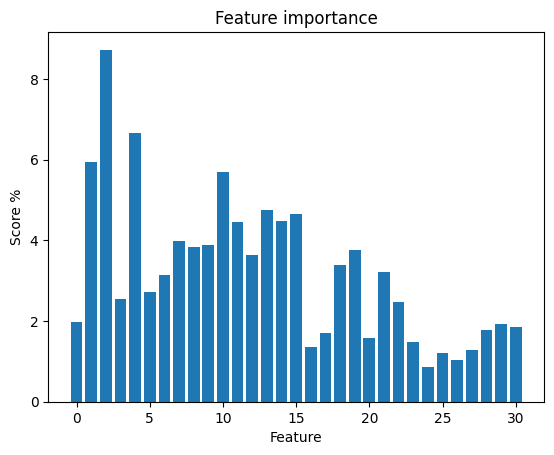

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.inspection import permutation_importance
from matplotlib import pyplot
columns = X_train_original_male_1.columns
# define dataset
# define the model
model = RandomForestClassifier()#KNeighborsClassifier()#XGBClassifier()#
# fit the model
model.fit(X_train_male,Y_train_male.ravel())
# get importance
importance = model.feature_importances_
#imp = permutation_importance(model, X, Y_onehot, scoring='neg_mean_squared_error')
# get importance
#importance = imp.importances_mean
# summarize feature importance
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance*100)
pyplot.xlabel("Feature")
pyplot.ylabel("Score %")
pyplot.title("Feature importance")
pyplot.show()


In [ ]:
column = []
for i in columns:
  column.append(i)


In [ ]:
np.array(column).shape

(31,)

In [ ]:
print(columns)

Index(['Race', 'Age_at_Release', 'Residence_PUMA', 'Gang_Affiliated',
       'Supervision_Risk_Score_First', 'Supervision_Level_First',
       'Education_Level', 'Dependents', 'Prison_Offense', 'Prison_Years',
       'Prior_Arrest_Episodes_Felony', 'Prior_Arrest_Episodes_Misd',
       'Prior_Arrest_Episodes_Violent', 'Prior_Arrest_Episodes_Property',
       'Prior_Arrest_Episodes_Drug',
       'Prior_Arrest_Episodes_PPViolationCharges',
       'Prior_Arrest_Episodes_DVCharges', 'Prior_Arrest_Episodes_GunCharges',
       'Prior_Conviction_Episodes_Felony', 'Prior_Conviction_Episodes_Misd',
       'Prior_Conviction_Episodes_Viol', 'Prior_Conviction_Episodes_Prop',
       'Prior_Conviction_Episodes_Drug',
       'Prior_Conviction_Episodes_PPViolationCharges',
       'Prior_Conviction_Episodes_DomesticViolenceCharges',
       'Prior_Conviction_Episodes_GunCharges', 'Prior_Revocations_Parole',
       'Prior_Revocations_Probation', 'Condition_MH_SA', 'Condition_Cog_Ed',
       'Condition_Oth

In [ ]:
print(importance)

[0.01979986 0.05945881 0.08729081 0.0254198  0.06651811 0.02725421
 0.0314305  0.03990123 0.03834526 0.03891981 0.05706075 0.04468836
 0.03628487 0.04763011 0.04486001 0.04664419 0.01348945 0.01692999
 0.03384828 0.03750661 0.0158385  0.03213085 0.0246903  0.01475288
 0.00863294 0.01206121 0.01032442 0.01287503 0.01772398 0.01925871
 0.01843018]


In [ ]:
feature_importance = pd.DataFrame(importance)
feature_importance.index = columns
feature_importance = feature_importance*100
feature_importance.columns = ["Percent (%) of feature importance"]
feature_importance

,Percent (%) of feature importance
Race,1.979986
Age_at_Release,5.945881
Residence_PUMA,8.729081
Gang_Affiliated,2.541980
Supervision_Risk_Score_First,6.651811
Supervision_Level_First,2.725421
Education_Level,3.143050
Dependents,3.990123
Prison_Offense,3.834526
Prison_Years,3.891981


In [ ]:
feature_importance.to_excel("feature_importance.xlsx",sheet_name='Feature importance')

# Model


First let's try a simple RandomForestClassifier

In [ ]:
forest_model = RandomForestClassifier(n_estimators = 1000,criterion = 'gini',random_state = 42) #1000 best
model_forest = forest_model.fit(X_train_male,Y_train_male.ravel())
score = forest_model.score(X_test_male,Y_test_male.ravel())

In [ ]:
k_fold = KFold(n_splits=10, shuffle=True,random_state=42)
scores = []
for k, (train, test) in enumerate(k_fold.split(X_train_male_1.values, Y_train_male_1.values)):
    forest_model.fit(X_train_male_1.values[train], Y_train_male_1.values[train])
    scores.append(forest_model.score(X_train_male_1.values[test], Y_train_male_1.values[test]))
print(np.mean(scores))

0.9165720211693598


In [ ]:
print("Accuracy score for male Random Forest Model is",100*score,"%")
print("KFold accuracy score for male RF is",100*np.mean(scores),"%")

Accuracy score for male Random Forest Model is 90.59073222497346 %
KFold accuracy score for male RF is 91.65720211693598 %


In [ ]:
forest_model_female = RandomForestClassifier(n_estimators = 1000,criterion = 'gini',random_state = 42) #1000 best
model_forest_female = forest_model_female.fit(X_train_female,Y_train_female.ravel())
score_female = forest_model_female.score(X_test_female,Y_test_female.ravel())
print("Accuracy score for female RF is:",score_female*100,"%")

Accuracy score for female RF is: 95.96928982725528 %


In [ ]:

y_predict = forest_model.predict(X_test_male)
print(y_predict) # 0 is False, 1 is True..

[0 1 0 ... 1 0 1]


Now let's try a DNN

In [ ]:
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)
dnn_model_score_male, dnn_model_male, model_history = Rec.simple_dnn_model(X_train_male,X_test_male,Y_train_male,Y_test_male)



/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/400
707/707 - 3s - 5ms/step - accuracy: 0.5904 - loss: 0.6901 - val_accuracy: 0.6289 - val_loss: 0.6416
Epoch 2/400
707/707 - 2s - 3ms/step - accuracy: 0.6265 - loss: 0.6414 - val_accuracy: 0.6445 - val_loss: 0.6335
Epoch 3/400
707/707 - 2s - 3ms/step - accuracy: 0.6347 - loss: 0.6330 - val_accuracy: 0.6441 - val_loss: 0.6311
Epoch 4/400
707/707 - 3s - 4ms/step - accuracy: 0.6441 - loss: 0.6263 - val_accuracy: 0.6417 - val_loss: 0.6307
Epoch 5/400
707/707 - 2s - 3ms/step - accuracy: 0.6502 - loss: 0.6204 - val_accuracy: 0.6427 - val_loss: 0.6287
Epoch 6/400
707/707 - 2s - 3ms/step - accuracy: 0.6548 - loss: 0.6138 - val_accuracy: 0.6441 - val_loss: 0.6261
Epoch 7/400
707/707 - 2s - 3ms/step - accuracy: 0.6632 - loss: 0.6064 - val_accuracy: 0.6466 - val_loss: 0.6229
Epoch 8/400
707/707 - 2s - 2ms/step - accuracy: 0.6736 - loss: 0.5990 - val_accuracy: 0.6516 - val_loss: 0.6207
Epoch 9/400
707/707 - 2s - 3ms/step - accuracy: 0.6801 - loss: 0.5909 - val_accuracy: 0.6562 - val_loss:

Baseline model accuracy

In [ ]:
print("Accuracy score is:",dnn_model_score_male[1])

Accuracy score is: 0.8365758657455444


Now we will use k-fold validation (10 folds) to see if our model generalizes well with different random splits

In [ ]:
from sklearn.model_selection import StratifiedKFold
from scikeras.wrappers import KerasClassifier

In [ ]:
def create_baseline_male():

	# create model

  model = Sequential()
  model.add(Dense(50, input_dim=31, activation='relu',kernel_initializer='he_uniform')) #input_dim=len(X_train_m) #20, 40 best
  model.add(Dense(100, activation='relu'))
  #model.add(Dropout(0.3))
  model.add(Dense(1, activation='sigmoid'))
  # Compile model
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model

# evaluate model with standardized dataset
early_stopping = EarlyStopping(patience = 50 , restore_best_weights=True, monitor='val_loss')
estimator = KerasClassifier(build_fn=create_baseline_male, epochs=2, batch_size=16, verbose=0, fit__callbacks=[early_stopping])
kfold = StratifiedKFold(n_splits=10, shuffle=True)
#results = cross_val_score(estimator, X_train_male_1.values,Y_train_male_1.values,cv=kfold)

AttributeError: 'super' object has no attribute '__sklearn_tags__'

In [ ]:
print("Baseline k-fold: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

The model has a small variance so it get can be trusted

Now make predictions based on the simple dnn model

In [ ]:
#estimator.fit(X_train_m,Y_train_m)
pred_forest = model_forest.predict(X_test_male)
pred_forest_prob = model_forest.predict_proba(X_test_male)#probability
pred = (dnn_model_male.predict(X_test_male)>0.5).astype("int32")#(estimator.model.predict(X_test_m) > 0.5).astype("int32")
pred_prob = dnn_model_male.predict(X_test_male)#probability

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [ ]:
from sklearn import metrics

results_score = metrics.accuracy_score(Y_test_male, pred_forest)
for i,j in zip(pred_forest,pred_forest_prob):
  print("Prediction is:" ,i,"Probability of Recidivism is:",j[1])
#0 = False, 1 = True
#print(pred_prob)

Prediction is: 0 Probability of Recidivism is: 0.212
Prediction is: 1 Probability of Recidivism is: 0.97
Prediction is: 0 Probability of Recidivism is: 0.127
Prediction is: 0 Probability of Recidivism is: 0.135
Prediction is: 1 Probability of Recidivism is: 1.0
Prediction is: 1 Probability of Recidivism is: 0.998
Prediction is: 0 Probability of Recidivism is: 0.183
Prediction is: 1 Probability of Recidivism is: 0.752
Prediction is: 1 Probability of Recidivism is: 0.999
Prediction is: 0 Probability of Recidivism is: 0.12
Prediction is: 1 Probability of Recidivism is: 0.978
Prediction is: 1 Probability of Recidivism is: 0.822
Prediction is: 1 Probability of Recidivism is: 0.924
Prediction is: 0 Probability of Recidivism is: 0.103
Prediction is: 1 Probability of Recidivism is: 0.996
Prediction is: 1 Probability of Recidivism is: 0.925
Prediction is: 1 Probability of Recidivism is: 0.986
Prediction is: 1 Probability of Recidivism is: 0.828
Prediction is: 0 Probability of Recidivism is: 0.2

In [ ]:
print("Accuracy score is:",dnn_model_score_male[1])


Accuracy score is: 0.8365758657455444


In [ ]:
pred_forest_prob

array([[0.788, 0.212],
       [0.03 , 0.97 ],
       [0.873, 0.127],
       ...,
       [0.037, 0.963],
       [0.984, 0.016],
       [0.032, 0.968]])

In [ ]:
from sklearn.metrics import brier_score_loss
print("Brier Score is:",brier_score_loss(Y_test_male,pred_prob)) #was 0.185
print("Brier Score forest is:",brier_score_loss(Y_test_male, pred_forest_prob[:,1]))

Brier Score is: 0.1509000036272183
Brier Score forest is: 0.011661101167315176


A Brier Score of 0 is perfect while 1 is considered the worst. Our score is above average and acceptable

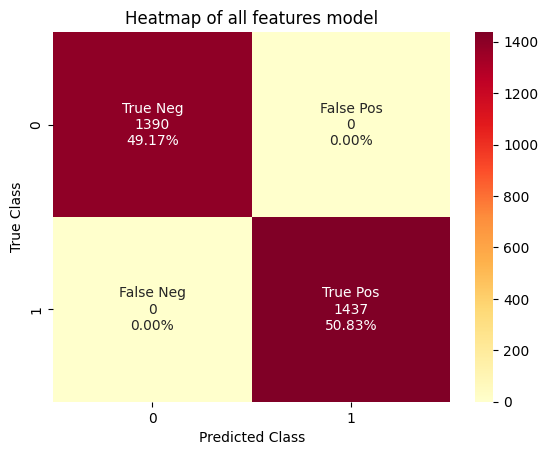

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
#cf = confusion_matrix(Y_test_m,pred)
cf = confusion_matrix(Y_test_male, pred_forest)
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                cf.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cf.flatten()/np.sum(cf)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
ax = sns.heatmap(cf, annot=labels, fmt='', cmap='YlOrRd')
plt.title('Heatmap of all features model')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.show() #True Pos was 2.18% and False Neg was 25.46%

Now we will predict on the original test set that has not been upsampled

In [ ]:
pred_forest_og = model_forest.predict(X_test_original_male)
pred_forest_prob_og = model_forest.predict_proba(X_test_original_male)
results_score_og = metrics.accuracy_score(Y_test_original_male, pred_forest_og)
print("Brier score is:",brier_score_loss(Y_test_original_male,pred_forest_prob_og[:,1]))
print("Accuracy is:", results_score_og)


Brier score is: 0.03535849288617886
Accuracy is: 0.9705284552845529


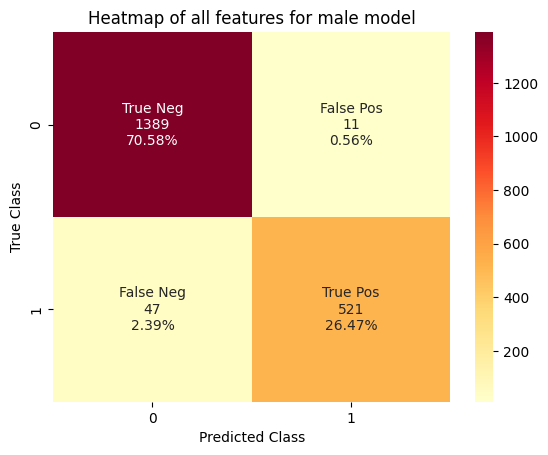

In [ ]:

#cf = confusion_matrix(Y_test_m,pred)
cf = confusion_matrix(Y_test_original_male, pred_forest_og)
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                cf.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cf.flatten()/np.sum(cf)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
ax = sns.heatmap(cf, annot=labels, fmt='', cmap='YlOrRd')
plt.title('Heatmap of all features for male model')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.show() #True Pos was 2.18% and False Neg was 25.46%

In [ ]:
pred_forest_female_og = model_forest_female.predict(X_test_original_female)
pred_forest_prob_female_og = model_forest_female.predict_proba(X_test_original_female)
results_score_og_female = metrics.accuracy_score(Y_test_original_female, pred_forest_female_og)
print("Brier score is:",brier_score_loss(Y_test_original_female,pred_forest_prob_female_og[:,1]))
print("Accuracy is:", results_score_og_female)

Brier score is: 0.028489602484472052
Accuracy is: 0.9782608695652174


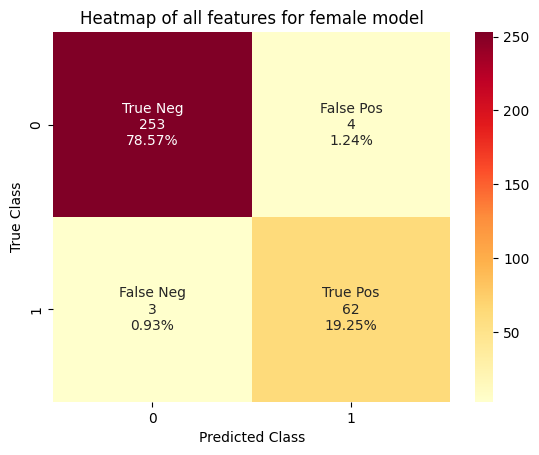

In [ ]:

#cf = confusion_matrix(Y_test_m,pred)
cf2 = confusion_matrix(Y_test_original_female, pred_forest_female_og)
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                cf2.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cf2.flatten()/np.sum(cf2)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
ax = sns.heatmap(cf2, annot=labels, fmt='', cmap='YlOrRd')
plt.title('Heatmap of all features for female model')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.show() #True Pos was 2.18% and False Neg was 25.46%

The predictions on the original test set are very good! Now we are ready to make our final predictions on the test set provided by the Challenge

In [ ]:
male_test_predictions = model_forest.predict_proba(male_labeled_test.values)
female_test_predictions = model_forest_female.predict_proba(female_labeled_test.values)

In [ ]:
male_test_predictions = male_test_predictions[:,1]
female_test_predictions = female_test_predictions[:,1]

In [ ]:
final_male_predictions = pd.DataFrame(male_test_predictions,index = male_test.index,columns=["Probability of Recidivism 1-year"])
zeros = np.zeros((len(male_test.index),1))
zeros = "True"
gender = zeros
final_male_predictions.join(pd.DataFrame(gender,index = male_test.index,columns=["Male"]))

,Probability of Recidivism 1-year,Male
ID,,
6,0.238,True
8,0.327,True
12,0.233,True
15,0.312,True
27,0.280,True
...,...,...
26672,0.085,True
26674,0.251,True
26679,0.094,True


In [ ]:
final_female_predictions = pd.DataFrame(female_test_predictions,index = female_test.index,columns=["Probability of Recidivism 1-year"])
zeros = np.zeros((len(female_test.index),1))
zeros = "True"
gender = zeros
final_female_predictions.join(pd.DataFrame(gender,index = female_test.index,columns=["Female"]))

,Probability of Recidivism 1-year,Female
ID,,
43,0.339,True
105,0.335,True
107,0.516,True
198,0.462,True
341,0.367,True
...,...,...
26577,0.334,True
26604,0.133,True
26617,0.444,True


In [ ]:
final_female_predictions.to_excel(r'Female-Predictions.xlsx', index = True)
final_male_predictions.to_excel(r'Male-Predictions.xlsx', index = True)

In [ ]:
final_predictions = pd.concat([final_male_predictions,final_female_predictions])

In [ ]:
final_predictions # this does not include the Male and Female Columns (concatenation doesn't work properly),so I just manually concatenated the two previous excel files (pasted ids of female to male after download and inserted Female column)

,Probability of Recidivism 1-year
ID,
6,0.238
8,0.327
12,0.233
15,0.312
27,0.280
...,...
26577,0.334
26604,0.133
26617,0.444
